In [16]:
# Import necessary libraries
import cdflib
import xarray as xr
import os
import urllib.request
import numpy as np
import pandas as pd
import datetime as dt
from tqdm import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import math

import sys
import h5py
import dask
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
import h5netcdf
import flox

In [2]:
fname = ['GR_OPER_TEC1TMS_2F_20130316T000000_20130316T235959_0101.cdf', 'GR_OPER_TEC1TMS_2F_20130317T000000_20130317T235959_0101.cdf', 'GR_OPER_TEC1TMS_2F_20130318T000000_20130318T235959_0101.cdf', 'GR_OPER_TEC2TMS_2F_20130316T000000_20130316T235959_0101.cdf', 'GR_OPER_TEC2TMS_2F_20130317T000000_20130317T235959_0101.cdf', 'GR_OPER_TEC2TMS_2F_20130318T000000_20130318T235959_0101.cdf']
grace_data = []

for f in tqdm(fname):
    path = 'ESA_GRACE_data/' + f
    data = xr.Dataset()
    d = cdflib.CDF(path)

    step = range(len(d['Timestamp']))
    
    for var_name in d.cdf_info().zVariables:
        
        var_data = d[var_name]

        if var_name == 'DCB' or var_name == 'DCB_Error' :
            data[var_name] = d[var_name]
        
        elif type(var_data[0]) == np.ndarray:
            var_name1 = var_name + '_X'
            var_name2 = var_name + '_Y'
            var_name3 = var_name + '_Z'
            data[var_name1] = ('step', [i for i,j,k in var_data], {'step': step})
            data[var_name2] = ('step', [j for i,j,k in var_data], {'step': step})
            data[var_name3] = ('step', [k for i,j,k in var_data], {'step': step})

        else:
            data[var_name] = ('step', var_data, {'step': step})


    d0 = dt.datetime.strptime(f.split('_')[4], '%Y%m%dT%f')
    date = [d0 + pd.Timedelta(milliseconds = (i - data.Timestamp[0].values)) for i in data.Timestamp.values]
    data['date'] = ('step', [i for i in date], {'step': step})

    grace_data.append(data)

print()
print('Columns in Satellite Data: \n', d.cdf_info().zVariables)
print()
print(data)


100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.36s/it]


Columns in Satellite Data: 
 ['Timestamp', 'Latitude', 'Longitude', 'Radius', 'GPS_Position', 'LEO_Position', 'PRN', 'L1', 'L2', 'P1', 'P2', 'S1_C_N0', 'S2_C_N0', 'Absolute_STEC', 'Absolute_VTEC', 'Elevation_Angle', 'Relative_STEC', 'Relative_STEC_RMS', 'DCB', 'DCB_Error']

<xarray.Dataset>
Dimensions:            (step: 56708)
Dimensions without coordinates: step
Data variables: (12/25)
    Timestamp          (step) float64 6.353e+13 6.353e+13 ... 6.353e+13
    Latitude           (step) float64 -60.57 -60.57 -60.57 ... 26.16 26.16 26.16
    Longitude          (step) float64 -175.0 -175.0 -175.0 ... 2.732 2.732 2.732
    Radius             (step) float64 6.825e+06 6.825e+06 ... 6.822e+06
    GPS_Position_X     (step) float64 -3.798e+06 -1.924e+07 ... 2.534e+07
    GPS_Position_Y     (step) float64 -1.475e+07 1.345e+07 ... -7.897e+06
    ...                 ...
    Elevation_Angle    (step) float64 43.01 37.0 30.6 ... 24.11 52.51 54.28
    Relative_STEC      (step) float64 86.47 56.26 8

In [44]:
fname = ['GR_OPER_NE__KBR_2F_20130228T000000_20130228T235959_0101.cdf']
grace_data = []

for f in tqdm(fname):
    path = 'ESA_GRACE_data/new/' + f
    data = xr.Dataset()
    d = cdflib.CDF(path)

    step = range(len(d['Timestamp']))
    
    for var_name in d.cdf_info().zVariables:
        var_data = d[var_name]

        if var_name == 'DCB' or var_name == 'DCB_Error' :
            data[var_name] = d[var_name]

        elif var_name == 'LEO_Position':
            continue
        elif type(var_data[0]) == np.ndarray:

            print(var_data)
            for p,q in var_data:
                print(p, q)
                
                var_name1 = var_name + '_pX'
                var_name2 = var_name + '_pY'
                var_name3 = var_name + '_pZ'
                data[var_name1] = ('step', [i for i,j,k in p], {'step': step})
                data[var_name2] = ('step', [j for i,j,k in p], {'step': step})
                data[var_name3] = ('step', [k for i,j,k in p], {'step': step})

                var_name1 = var_name + '_qX'
                var_name2 = var_name + '_qY'
                var_name3 = var_name + '_qZ'
                data[var_name1] = ('step', [i for i,j,k in q], {'step': step})
                data[var_name2] = ('step', [j for i,j,k in q], {'step': step})
                data[var_name3] = ('step', [k for i,j,k in q], {'step': step})

        else:
            data[var_name] = ('step', var_data, {'step': step})

'''
    d0 = dt.datetime.strptime(f.split('_')[4], '%Y%m%dT%f')
    date = [d0 + pd.Timedelta(milliseconds = (i - data.Timestamp[0].values)) for i in data.Timestamp.values]
    data['date'] = ('step', [i for i in date], {'step': step})

    grace_data.append(data)
'''
print()
print('Columns in Satellite Data: \n', d.cdf_info().zVariables)
print()
print(data)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 45.69it/s]


Columns in Satellite Data: 
 ['Timestamp', 'Latitude', 'Longitude', 'Radius', 'LEO_Position', 'Distance', 'Relative_Hor_TEC', 'Relative_Ne', 'Absolute_Ne']

<xarray.Dataset>
Dimensions:           (step: 8987)
Dimensions without coordinates: step
Data variables:
    Timestamp         (step) float64 6.353e+13 6.353e+13 ... 6.353e+13 6.353e+13
    Latitude          (step) float64 77.37 77.05 76.73 ... 73.37 73.05 72.73
    Longitude         (step) float64 -160.9 -160.8 -160.7 ... 12.46 12.5 12.54
    Radius            (step) float64 6.815e+06 6.815e+06 ... 6.814e+06 6.814e+06
    Distance          (step) float64 1.989e+05 1.989e+05 ... 1.98e+05 1.98e+05
    Relative_Hor_TEC  (step) float64 -2.913 -2.846 -2.755 ... -2.591 -2.573
    Relative_Ne       (step) float64 -1.465e+11 -1.431e+11 ... -1.299e+11
    Absolute_Ne       (step) float64 1.583e+11 1.617e+11 ... 1.74e+11 1.749e+11


In [5]:
grace_data[0].data_vars

Data variables:
    Timestamp          (step) float64 6.353e+13 6.353e+13 ... 6.353e+13
    Latitude           (step) float64 -56.91 -56.91 -56.91 ... 88.52 88.52 88.52
    Longitude          (step) float64 3.965 3.965 3.965 ... 45.42 45.42 45.42
    Radius             (step) float64 6.833e+06 6.833e+06 ... 6.806e+06
    GPS_Position_X     (step) float64 8.967e+05 9.566e+06 ... 8.504e+06 1.51e+07
    GPS_Position_Y     (step) float64 -1.838e+07 2.261e+07 ... -5.75e+06
    GPS_Position_Z     (step) float64 -1.952e+07 -1.043e+07 ... 2.072e+07
    LEO_Position_X     (step) float64 3.721e+06 3.721e+06 ... 1.237e+05
    LEO_Position_Y     (step) float64 2.579e+05 2.579e+05 ... 1.255e+05
    LEO_Position_Z     (step) float64 -5.725e+06 -5.725e+06 ... 6.804e+06
    PRN                (step) uint16 11 12 14 18 11 12 14 ... 10 13 16 23 29 30
    L1                 (step) float64 2.346e+07 2.354e+07 ... 2.134e+07
    L2                 (step) float64 2.346e+07 2.354e+07 ... 2.134e+07
    P1     

### Note
- LEO_Position given in the data are the positions of the GRACE satellite in the ECEF cartesian system (WGS84 is being used) and units are in meters
- GPS_Position given in the data are the positions of the GPS satellites
- Latitude, Longitude, and Radius represent the position of the GRACE satellite and they are in the spherical coordinates system (Geocentric or ECEF spherical system)
- Absolute VTEC is recommended to be calculated by using GPS rays of elevation angle as at least 50 degrees (in documentation).

In [7]:
d1 = grace_data[1]

selsd = d1.where(d1.Timestamp <= d1.Timestamp.values[4000], drop=True)

print('Unique Timestamps -', len(np.unique(selsd.Timestamp.values)))
print('Unique PRN -', np.unique(selsd.PRN))

Unique Timestamps - 618
Unique PRN - [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 16. 17. 18. 19. 20.
 21. 22. 23. 25. 26. 28. 29. 30. 31. 32.]


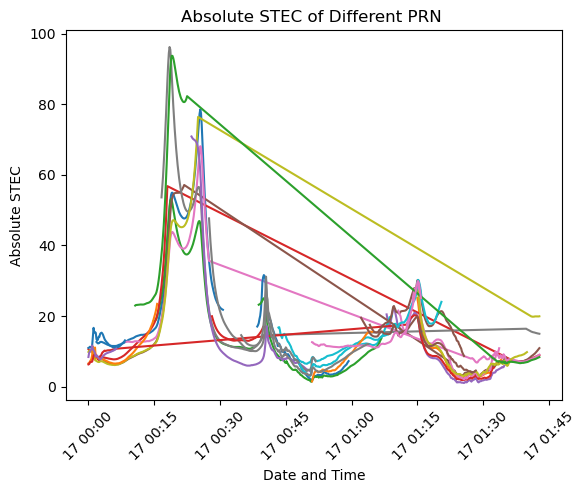

In [8]:
for prn in np.unique(selsd.PRN):

    seld2 = selsd.where(selsd.PRN == prn, drop = True)
    
    plt.plot(seld2.date, seld2.Absolute_STEC)
    plt.xticks(rotation=45)
    plt.xlabel('Date and Time')
    plt.ylabel('Absolute STEC')
    plt.title('Absolute STEC of Different PRN ')

plt.show()

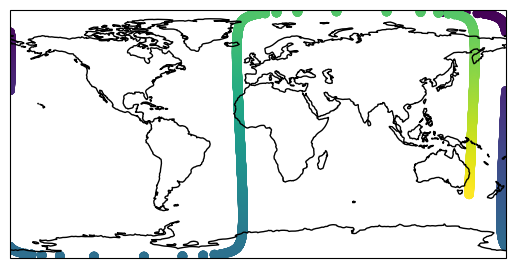

In [9]:
ax = plt.subplot(projection=ccrs.PlateCarree())


ma = 5000

ax.scatter(d1.Longitude.values[:ma], d1.Latitude.values[:ma], c=d1.Timestamp.values[:ma])

ax.coastlines()


In [10]:
d1.data_vars

Data variables:
    Timestamp          (step) float64 6.353e+13 6.353e+13 ... 6.353e+13
    Latitude           (step) float64 88.73 88.73 88.73 ... -57.2 -57.2 -57.2
    Longitude          (step) float64 134.2 134.2 134.2 ... -175.1 -175.1 -175.1
    Radius             (step) float64 6.806e+06 6.806e+06 ... 6.825e+06
    GPS_Position_X     (step) float64 -6.162e+06 -1.878e+07 ... -3.354e+06
    GPS_Position_Y     (step) float64 1.532e+07 -1.001e+06 ... -2.177e+07
    GPS_Position_Z     (step) float64 2.075e+07 1.862e+07 ... -1.507e+07
    LEO_Position_X     (step) float64 -1.049e+05 -1.049e+05 ... -3.683e+06
    LEO_Position_Y     (step) float64 1.079e+05 1.079e+05 ... -3.128e+05
    LEO_Position_Z     (step) float64 6.804e+06 6.804e+06 ... -5.737e+06
    PRN                (step) uint16 5 10 13 16 23 29 5 ... 32 9 11 17 20 28 32
    L1                 (step) float64 2.162e+07 2.215e+07 ... 2.356e+07
    L2                 (step) float64 2.162e+07 2.215e+07 ... 2.356e+07
    P1        

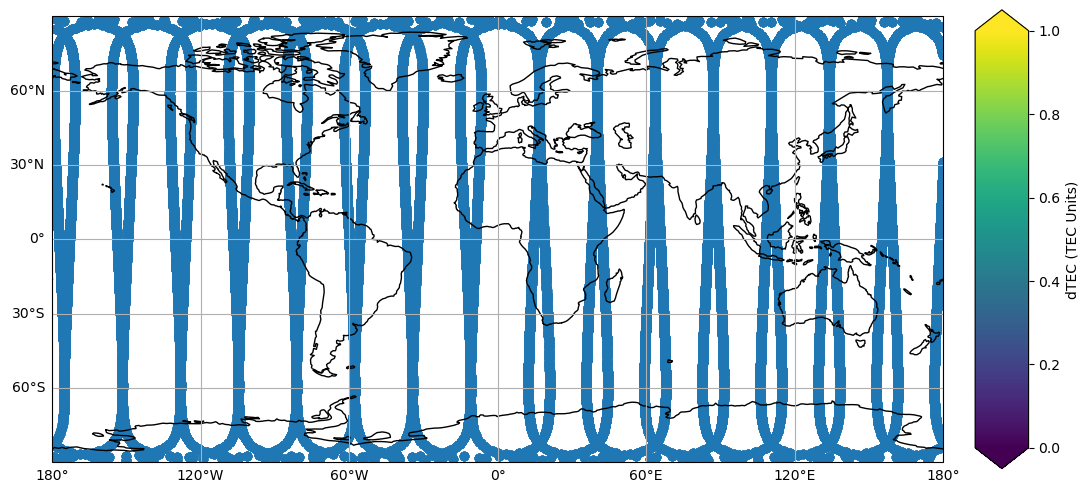

In [11]:

fig, axs = plt.subplots(1, 2, width_ratios=(1,.06), figsize=(11,5), 
                        subplot_kw={'projection':ccrs.PlateCarree()})
# ax0 = fig.add_subplot(1,5,, projection=ccrs.PlateCarree())

axs[1].remove()
axs[1] = fig.add_subplot(1,2,2)


f = axs[0].scatter(d1.Longitude, d1.Latitude)

axs[0].coastlines()
axs[0].gridlines(draw_labels=['bottom', 'left'])

plt.colorbar(f, cax=axs[1], label='dTEC (TEC Units)', extend='both')

# axs[0].ccrs.PlateCarree()

fig.tight_layout()
fig.show();

In [25]:
print(math.degrees(math.atan(1)))

45.0


In [30]:
import ecef_geodetic
import importlib as il

ecef_geodetic = il.reload(ecef_geodetic)

lat_gps = []
lon_gps = []
alt_gps = []

lat_leo = []
lon_leo = []
alt_leo = []

x_geod = []
y_geod = []
z_geod = []

radius_check = []

for x,y,z in tqdm(zip(d1.GPS_Position_X, d1.GPS_Position_Y, d1.GPS_Position_Z)):
    lat, lon, alt = ecef_geodetic.ecef_to_lla(x,y,z)
    lat_gps.append(lat)
    lon_gps.append(lon)
    alt_gps.append(alt)

for x,y,z in tqdm(zip(d1.LEO_Position_X, d1.LEO_Position_Y, d1.LEO_Position_Z)):
    lat, lon, alt = ecef_geodetic.cart_spher(x,y,z)
    lat_leo.append(lat)
    lon_leo.append(lon)
    alt_leo.append(alt)

for lat,lon,h in tqdm(zip(d1.Latitude, d1.Longitude, d1.Radius)):
    x, y, z = ecef_geodetic.spher_cart(lat,lon,h)
    x_geod.append(x)
    y_geod.append(y)
    z_geod.append(z)

d1['GPS_lat'] = ('step', lat_gps, {'step': step})
d1['GPS_lon'] = ('step', lon_gps, {'step': step})
d1['GPS_alt'] = ('step', alt_gps, {'step': step})
d1['LEO_lat'] = ('step', lat_leo, {'step': step})
d1['LEO_lon'] = ('step', lon_leo, {'step': step})
d1['LEO_alt'] = ('step', alt_leo, {'step': step})
d1['Geod_X'] = ('step', x_geod, {'step': step})
d1['Geod_Y'] = ('step', y_geod, {'step': step})
d1['Geod_Z'] = ('step', z_geod, {'step': step})

54985it [00:19, 2885.30it/s]
54985it [01:17, 707.58it/s]
54985it [00:15, 3468.05it/s]


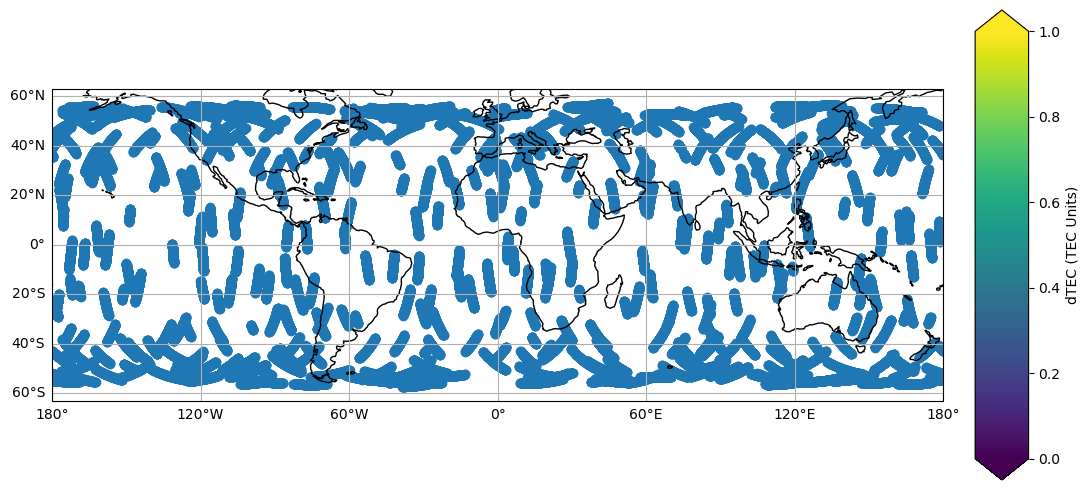

In [13]:

fig, axs = plt.subplots(1, 2, width_ratios=(1,.06), figsize=(11,5), 
                        subplot_kw={'projection':ccrs.PlateCarree()})
# ax0 = fig.add_subplot(1,5,, projection=ccrs.PlateCarree())

axs[1].remove()
axs[1] = fig.add_subplot(1,2,2)


f = axs[0].scatter(d1.GPS_lon, d1.GPS_lat)

axs[0].coastlines()
axs[0].gridlines(draw_labels=['bottom', 'left'])

plt.colorbar(f, cax=axs[1], label='dTEC (TEC Units)', extend='both')

# axs[0].ccrs.PlateCarree()

fig.tight_layout()
fig.show();

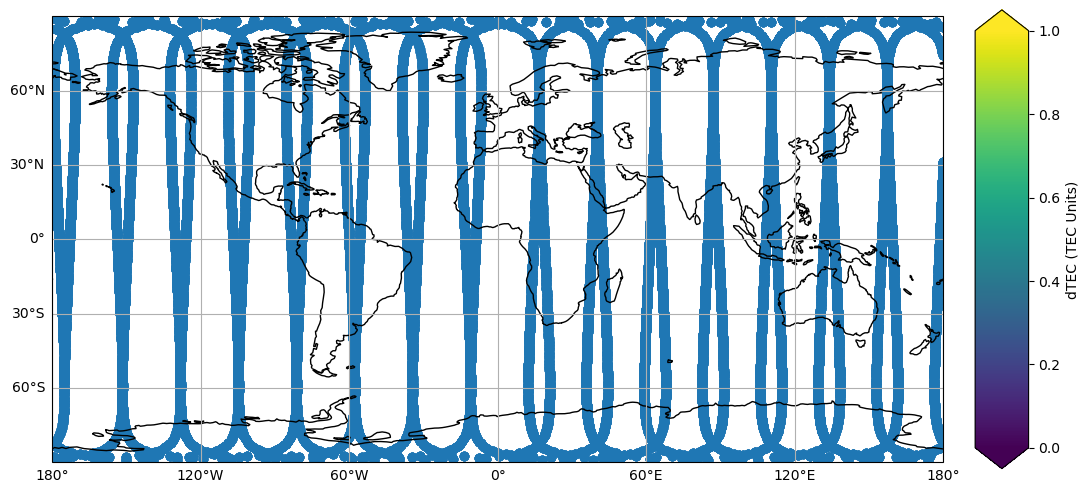

In [14]:

fig, axs = plt.subplots(1, 2, width_ratios=(1,.06), figsize=(11,5), 
                        subplot_kw={'projection':ccrs.PlateCarree()})
# ax0 = fig.add_subplot(1,5,, projection=ccrs.PlateCarree())

axs[1].remove()
axs[1] = fig.add_subplot(1,2,2)


f = axs[0].scatter(d1.LEO_lon, d1.LEO_lat)

axs[0].coastlines()
axs[0].gridlines(draw_labels=['bottom', 'left'])

plt.colorbar(f, cax=axs[1], label='dTEC (TEC Units)', extend='both')

# axs[0].ccrs.PlateCarree()

fig.tight_layout()
fig.show();

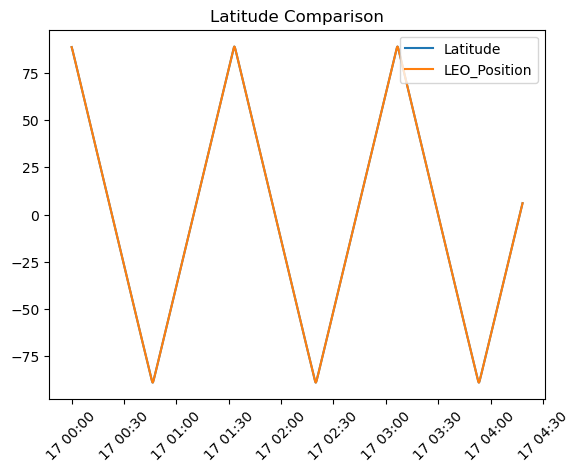

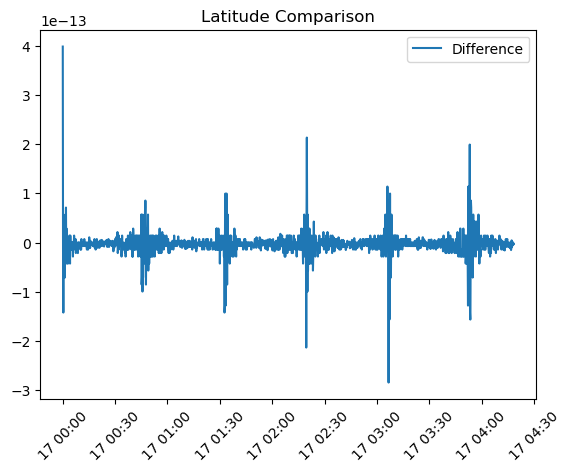

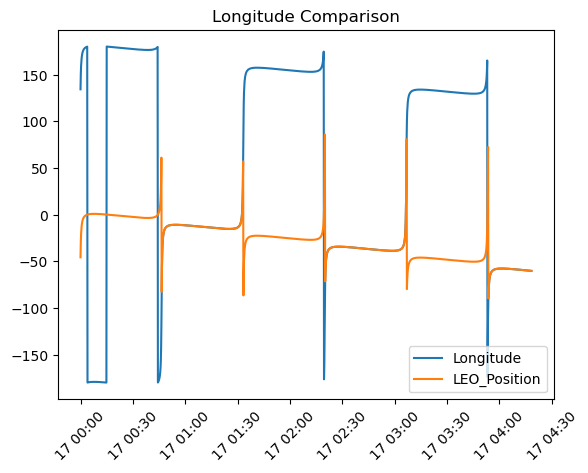

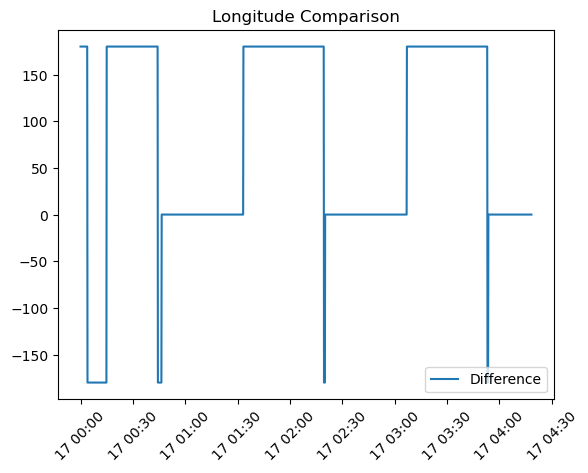

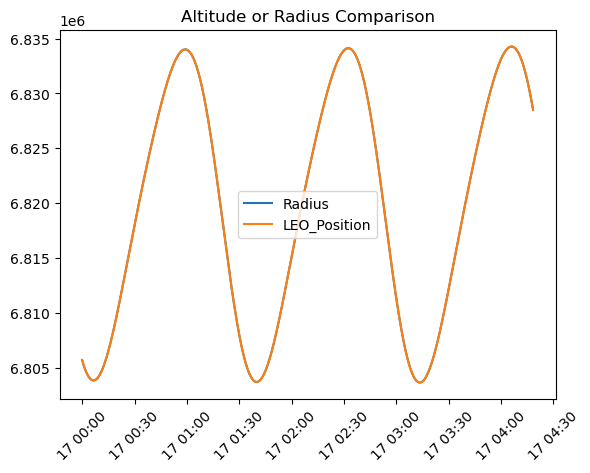

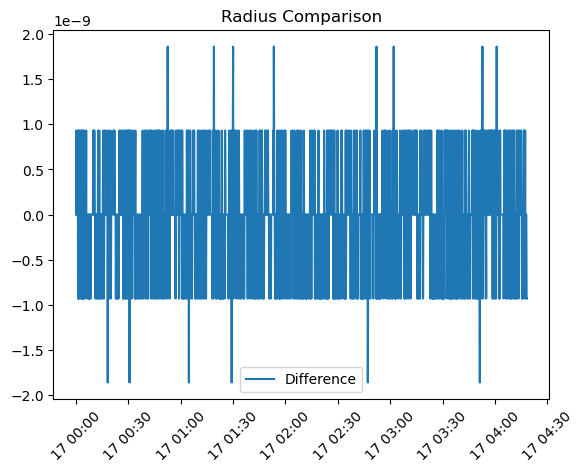

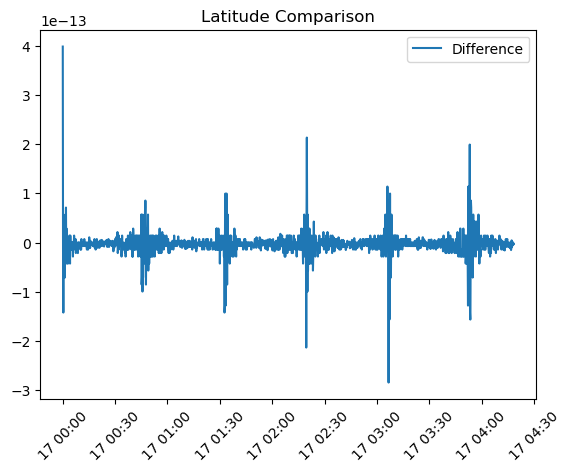

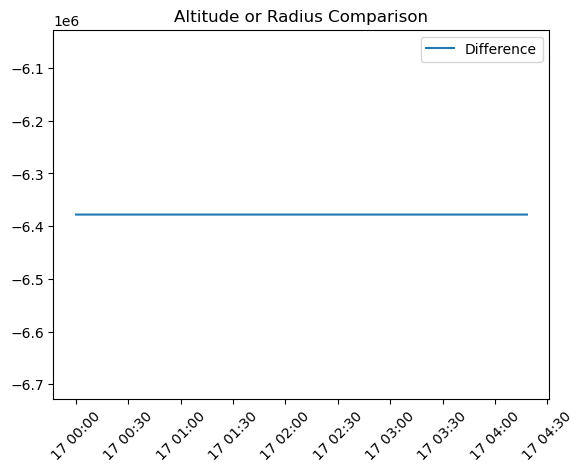

In [31]:
a = 0
b = 10000

plt.figure()
plt.plot(d1.date[a:b], d1.Latitude.values[a:b], label='Latitude')
plt.plot(d1.date[a:b], d1.LEO_lat.values[a:b], label='LEO_Position')
plt.title('Latitude Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Latitude.values[a:b] - d1.LEO_lat.values[a:b], label='Difference')
plt.title('Latitude Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Longitude.values[a:b], label='Longitude')
plt.plot(d1.date[a:b], d1.LEO_lon.values[a:b], label='LEO_Position')
plt.title('Longitude Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Longitude.values[a:b] - d1.LEO_lon.values[a:b], label='Difference')
plt.title('Longitude Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Radius.values[a:b], label='Radius')
plt.plot(d1.date[a:b], d1.LEO_alt.values[a:b], label='LEO_Position')
plt.title('Altitude or Radius Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Radius.values[a:b] - d1.LEO_alt.values[a:b], label='Difference')
plt.title('Radius Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()



plt.figure()
plt.plot(d1.date[a:b], d1.Latitude.values[a:b] - d1.LEO_lat.values[a:b], label='Difference')
plt.title('Latitude Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()


plt.figure()
plt.plot(d1.date[a:b], d1.Radius.values[a:b] - (d1.LEO_alt.values[a:b] + 6378000), label='Difference')
plt.title('Altitude or Radius Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

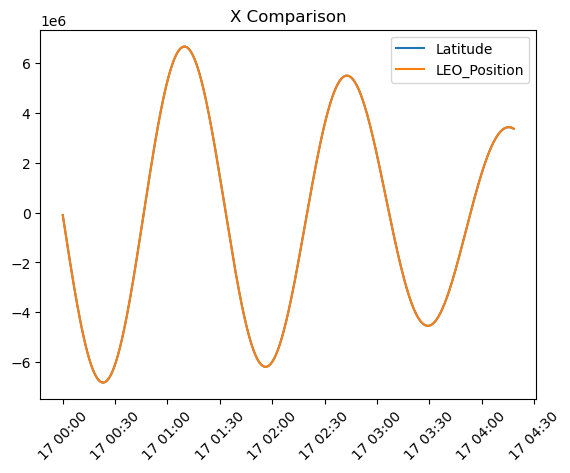

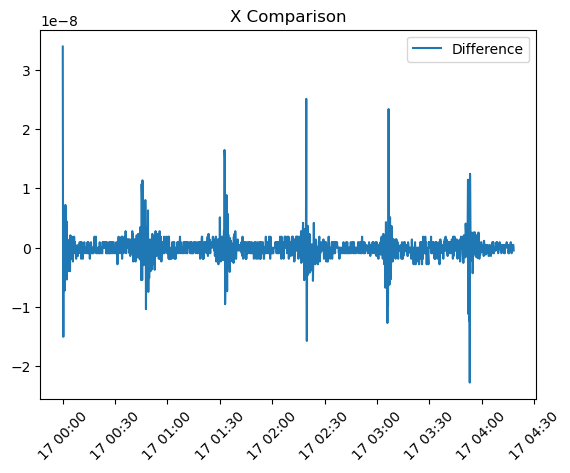

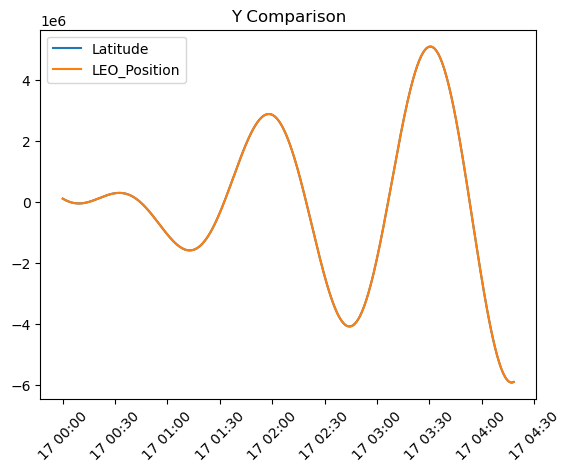

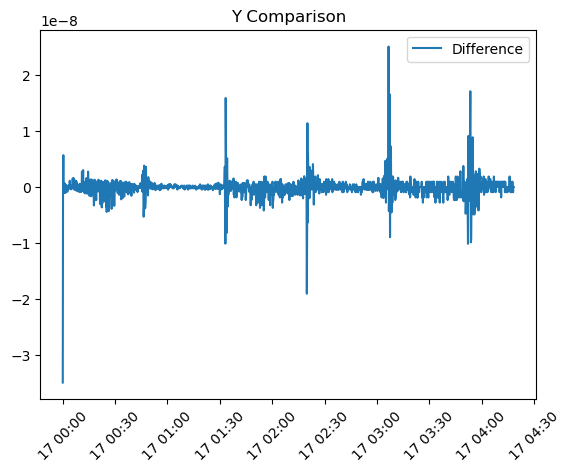

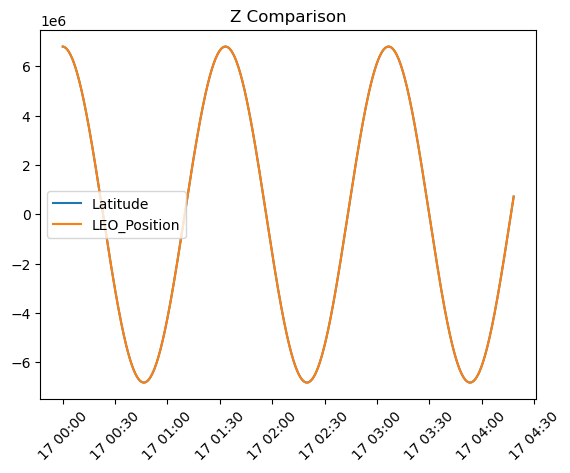

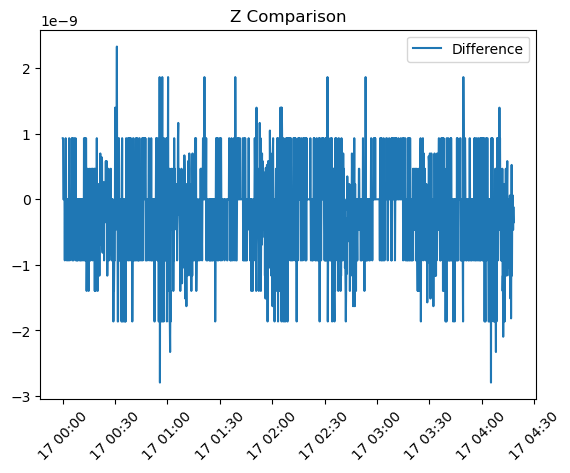

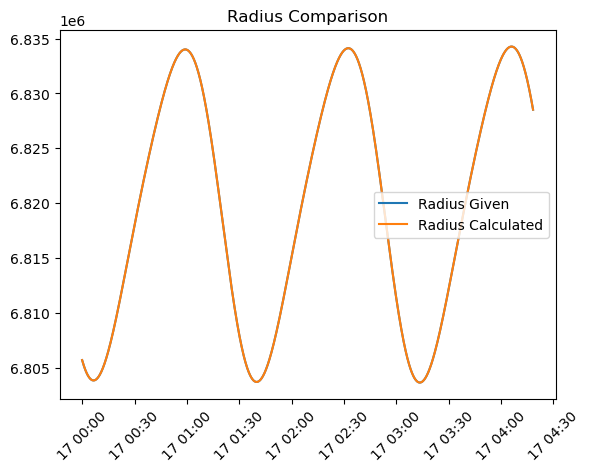

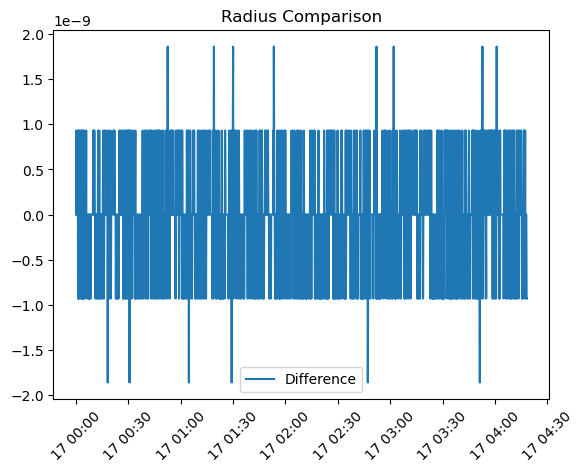

In [22]:
a = 0
b = 10000

plt.figure()
plt.plot(d1.date[a:b], d1.Geod_X.values[a:b], label='Latitude')
plt.plot(d1.date[a:b], d1.LEO_Position_X.values[a:b], label='LEO_Position')
plt.title('X Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Geod_X.values[a:b] - d1.LEO_Position_X.values[a:b], label='Difference')
plt.title('X Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Geod_Y.values[a:b], label='Latitude')
plt.plot(d1.date[a:b], d1.LEO_Position_Y.values[a:b], label='LEO_Position')
plt.title('Y Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Geod_Y.values[a:b] - d1.LEO_Position_Y.values[a:b], label='Difference')
plt.title('Y Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Geod_Z.values[a:b], label='Latitude')
plt.plot(d1.date[a:b], d1.LEO_Position_Z.values[a:b], label='LEO_Position')
plt.title('Z Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Geod_Z.values[a:b] - d1.LEO_Position_Z.values[a:b], label='Difference')
plt.title('Z Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Radius[a:b], label='Radius Given')
plt.plot(d1.date[a:b], d1.Radius_check[a:b], label='Radius Calculated')
plt.title('Radius Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Radius[a:b] - d1.Radius_check[a:b], label='Difference')
plt.title('Radius Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [65]:
y = np.array([1,2,3,9,15,16,17,18,19,20,31,32,33,44,45])
split = np.where(np.diff(y) > 3)
print(split)
for s in split:
    print(y[s])


sel = np.where(np.diff(y) > 2)
print(len(sel[0]), sel)
yn = np.split(y, sel[0]+1)
print(yn)

(array([ 2,  3,  9, 12]),)
[ 3  9 20 33]
4 (array([ 2,  3,  9, 12]),)
[array([1, 2, 3]), array([9]), array([15, 16, 17, 18, 19, 20]), array([31, 32, 33]), array([44, 45])]


In [99]:
dn = d1.groupby('PRN') # 1, 24, 27 PRN is not present in grace_data[0]
prn = np.unique(d1.PRN)

print(dn)
print()

# All the timestamps are at the gap of 10 seconds
print(np.unique(d1.date.dt.time.values)[:10])

r = d1.date[:10]
print(r)
splits = np.where(np.diff(r.dt.second.values) > 5)
print(splits)

DatasetGroupBy, grouped over 'PRN'
29 groups with labels 2, 3, 4, 5, 6, 7, ..., 28, 29, 30, 31, 32.

[datetime.time(0, 0) datetime.time(0, 0, 10) datetime.time(0, 0, 20)
 datetime.time(0, 0, 30) datetime.time(0, 0, 40) datetime.time(0, 0, 50)
 datetime.time(0, 1) datetime.time(0, 1, 10) datetime.time(0, 1, 20)
 datetime.time(0, 1, 30)]
<xarray.DataArray 'date' (step: 10)>
array(['2013-03-17T00:00:00.000000000', '2013-03-17T00:00:00.000000000',
       '2013-03-17T00:00:00.000000000', '2013-03-17T00:00:00.000000000',
       '2013-03-17T00:00:00.000000000', '2013-03-17T00:00:00.000000000',
       '2013-03-17T00:00:10.000000000', '2013-03-17T00:00:10.000000000',
       '2013-03-17T00:00:10.000000000', '2013-03-17T00:00:10.000000000'],
      dtype='datetime64[ns]')
Dimensions without coordinates: step
Attributes:
    step:     range(0, 54985)
(array([5]),)


In [120]:
print(len(np.unique((d1.LEO_Position_X.values))))
print(len(np.unique((d1.LEO_Position_Y.values))))
print(len(np.unique((d1.LEO_Position_Z.values))))


xout = pd.date_range(d1.date.min().values, d1.date.max().values, 2880)
times = []
out_lat  = []
out_lon  = []
out_tec  = []
out_dtec = []
out_los = []

skipped=0

d1loc = list(d1.groupby('LEO_Position_X'))

for n, d in tqdm(d1loc):
    d2 = d.groupby('LEO_Position_Y')
    
    for _, d3 in d2:
        
        d4 = d3.groupby('PRN')

        for sat_num, d5 in d4:
            first = True
            splits = np.where(np.diff(d5.date.dt.second.values) > 20) # Split if there is a break of more than 5 minutes
            print(splits)
            
            for s in splits:
                data = {}

                for v in d5.data_vars:
                    #print(v)
                    if v == 'DCB' or v == 'DCB_Error':
                        continue
                    data[v] = np.split(d5[v].values, s+1)
                    
                for ipass in range(len(data['Absolute_STEC'])):
                    
                    sel = np.where(data['Absolute_STEC'][ipass] < 1)

                    if len(sel[0]) > 20:
                        xin = data['date'][ipass][sel].astype(int)
                        num_secs = pd.Timedelta(xin[-1] - xin[0]).total_seconds()

                        if num_secs > 1800:
                            yin = data['Absolute_STEC'][ipass][sel]
                            
                            _,in_indx = np.unique(xin,return_index=True)
                            if len(in_indx) != len(xin):
                                skipped += 1

                                continue
                            yout = CubicSpline(xin, yin)(xout, extrapolate=False)
                            fit = np.empty(yout.shape)
                            fit[~np.isnan(yout)] = savgol_filter(yout[~np.isnan(yout)], 60, 1, mode='interp')
                            out_dtec.append(yout - fit)
                            
                            out_lat.append(CubicSpline(xin, data['gdlat'][ipass][sel])(xout, extrapolate=False))
                            out_lon.append(CubicSpline(xin, data['glon'][ipass][sel])(xout, extrapolate=False))
                            out_tec.append(CubicSpline(xin, data['tec'][ipass][sel])(xout, extrapolate=False))
                            out_los.append(CubicSpline(xin, data['los_tec'][ipass][sel])(xout, extrapolate=False))
                            print(sat_num)

            


8638
8638
8638


  0%|                                         | 17/8638 [00:00<01:51, 77.25it/s]

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

  1%|▏                                        | 49/8638 [00:00<01:55, 74.35it/s]

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

  1%|▎                                        | 65/8638 [00:00<01:56, 73.42it/s]

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

  1%|▍                                        | 89/8638 [00:01<01:57, 73.05it/s]

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

  1%|▍                                       | 105/8638 [00:01<01:57, 72.72it/s]

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

  1%|▌                                       | 121/8638 [00:01<01:57, 72.77it/s]

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

  2%|▋                                       | 137/8638 [00:01<01:58, 72.00it/s]

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

  2%|▋                                       | 151/8638 [00:02<01:55, 73.28it/s]


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

KeyboardInterrupt: 

In [114]:
print(out_lat)

[]


In [86]:
print(d1.date.dt.time.values[:10])

print(d1.data_vars)

[datetime.time(0, 0) datetime.time(0, 0) datetime.time(0, 0)
 datetime.time(0, 0) datetime.time(0, 0) datetime.time(0, 0)
 datetime.time(0, 0, 10) datetime.time(0, 0, 10) datetime.time(0, 0, 10)
 datetime.time(0, 0, 10)]
Data variables:
    Timestamp          (step) float64 6.353e+13 6.353e+13 ... 6.353e+13
    Latitude           (step) float64 88.73 88.73 88.73 ... -57.2 -57.2 -57.2
    Longitude          (step) float64 134.2 134.2 134.2 ... -175.1 -175.1 -175.1
    Radius             (step) float64 6.806e+06 6.806e+06 ... 6.825e+06
    GPS_Position_X     (step) float64 -6.162e+06 -1.878e+07 ... -3.354e+06
    GPS_Position_Y     (step) float64 1.532e+07 -1.001e+06 ... -2.177e+07
    GPS_Position_Z     (step) float64 2.075e+07 1.862e+07 ... -1.507e+07
    LEO_Position_X     (step) float64 -1.049e+05 -1.049e+05 ... -3.683e+06
    LEO_Position_Y     (step) float64 1.079e+05 1.079e+05 ... -3.128e+05
    LEO_Position_Z     (step) float64 6.804e+06 6.804e+06 ... -5.737e+06
    PRN          